最后，通过封装好的框架，建立一个基准模型

In [305]:
import os
os.chdir('d:/future/index_future_prediction/Index_Future_Prediction')

import numpy as np
import pandas as pd

import torch
import torch.nn as nn
from torch.nn import functional as F
from torch.optim import lr_scheduler, Adam, AdamW

import warnings
warnings.filterwarnings("ignore", category=FutureWarning)

In [306]:
from utils.back_test import BackTest

In [307]:
feature = pd.read_csv('data/feature.csv', index_col='Unnamed: 0')
feature.dropna(inplace=True)
feature = feature.set_index('trade_date')
for i in feature.columns:
    feature[i] = (feature[i] - feature[i].mean())/ feature[i].std()

label = pd.read_csv('data/label.csv', index_col='Unnamed: 0')
label = label.set_index('trade_date')
data = pd.concat([feature, label], axis = 1)

In [308]:
from utils.random_split import RandomSplit

data_set = RandomSplit(data, 'cuda:0')
data_set.set_output(feature.columns, dtype = torch.float32, unfold = True)
data_set.set_output(['ch_next_week', 'down_probability', 'middle_probability', 'up_probability'], dtype = torch.float32, unfold = False)
train_set, validation_set, test_set = data_set.get_split_data(700, 250, 250, 30)

In [309]:
label.describe()

,ch_next_week,alter_std,down_probability,middle_probability,up_probability
count,1859.000000,1860.000000,1.859000e+03,1859.000000,1.859000e+03
mean,0.788667,79.000000,3.234378e-01,0.350571,3.259911e-01
std,79.631744,34.649708,2.629507e-01,0.169994,2.600157e-01
min,-376.128300,25.596879,2.106471e-09,0.000014,2.905489e-09
25%,-42.558550,53.500076,1.049049e-01,0.239887,1.051040e-01
50%,0.453600,73.459044,2.723034e-01,0.342380,2.724897e-01
75%,45.083600,95.088000,4.880362e-01,0.457958,5.006309e-01
max,512.379500,300.223384,9.999566e-01,0.882132,9.999859e-01


In [310]:
from utils.hybrid_loss import HybridLoss
loss_fn = HybridLoss(alpha = 1e-3, delta = 1)

In [311]:
from utils.prediction_recorder import PredictionRecorder
recorder = PredictionRecorder(is_logits = True)

In [312]:
import matplotlib.pyplot as plt

In [313]:
from utils.train_animator import TrainAnimator
animator = TrainAnimator(figsize=(12,6))

Animator data has been reset.


In [314]:
from utils.hybrid_decoder import HybridDecoder

class Baseline_LSTM(nn.Module):
    """循环神经网络模型"""
    def __init__(self, input_size, hidden_size,num_layers, dropout, **kwargs):
        super(Baseline_LSTM, self).__init__(**kwargs)
        self.device = 'cuda:0'
        self.process = nn.LSTM(
            input_size = input_size,
            hidden_size = hidden_size,
            num_layers = num_layers,
            dropout = dropout,
            batch_first = True,
            # nonlinearity='relu',
        )
        self.output = HybridDecoder(dim_state = hidden_size, init_prob = [0.0,0.05,0.0])

    def forward(self, x):
        random_drop = np.random.randint(0, 20)
        x = x[:,random_drop:,:]
        return self.output(self.process(x)[0][:,-1,:])

In [315]:
model = Baseline_LSTM(input_size = 17,
                      hidden_size = 17 * 2,
                      num_layers = 2,
                      dropout = 0.5,
                      ).to('cuda:0')

optimizer = torch.optim.AdamW(model.parameters(), lr=1e-4, weight_decay = 1e-1)
scheduler = lr_scheduler.StepLR(optimizer, step_size=1, gamma=0.95)


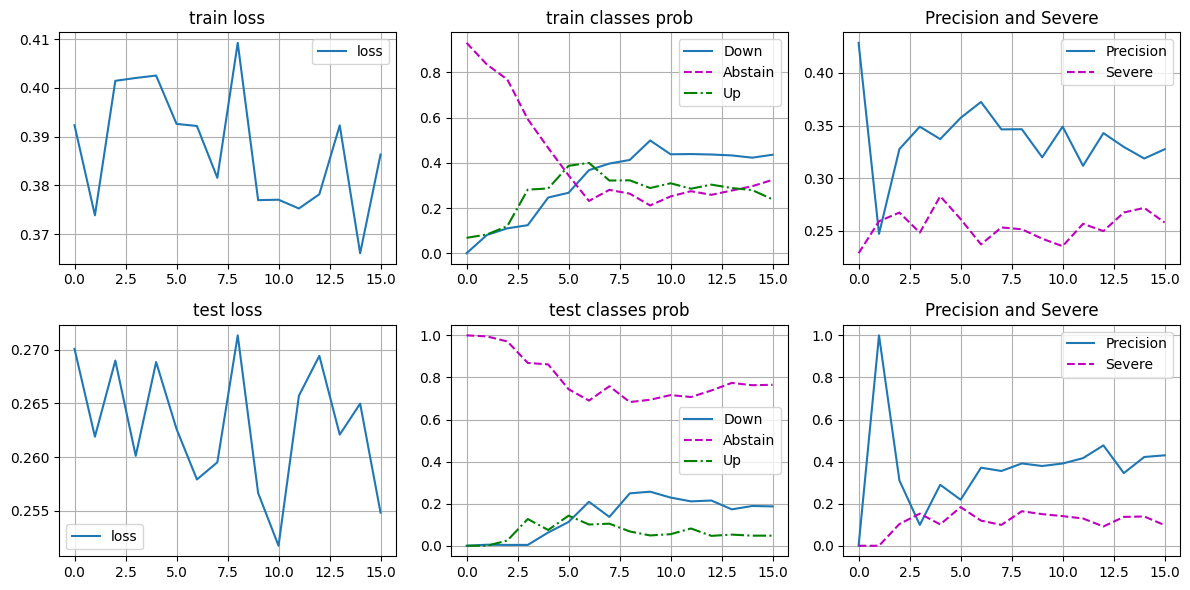

100%|██████████| 100/100 [00:00<00:00, 554.48it/s]


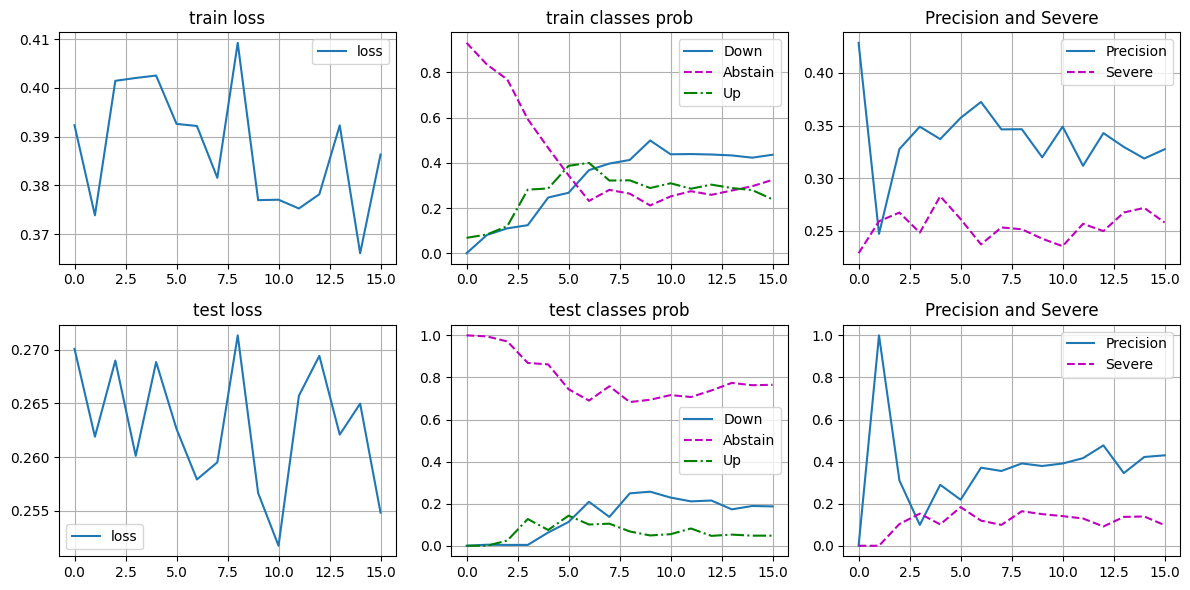

In [316]:
from utils.model_train import ModelTrain
train = ModelTrain(model = model,
                   train_set = train_set,
                   validation_set=validation_set,
                   test_set=test_set,
                   loss_fn = loss_fn,
                   optimizer = optimizer,
                   scheduler=scheduler,
                   recorder=recorder,
                   graph=animator,
                   threshold = 45,
                   )
train.epoch_train(epochs = 15, round = 100, early_stop = 30)

In [317]:
print(BackTest(model, *train_set.all(),sliding_window=5,init_value=3000))
train.round(round = 100, is_train = False, use_set = 'train', print_summary = True)

yearly return :11.71%
std           :93.97%
sharpe ratio  :0.09


100%|██████████| 100/100 [00:00<00:00, 482.95it/s]


,Prediction Ratio,Precision: Right/Pred,Severe: Wrong/Pred,Real Ratio,Accuracy: Right/Real
分类 0 (悲观),41.00%,36.10%,27.32%,28.90%,51.21%
分类 1 (放弃),30.60%,50.65%,0.00%,43.00%,36.05%
分类 2 (乐观),28.40%,34.51%,21.48%,28.10%,34.88%
分类 0 + 分类 2,69.40%,35.45%,24.93%,57.00%,43.16%


In [318]:
print(BackTest(model, *validation_set.all(),sliding_window=5,init_value=3000))
train.round(round = 100, is_train = False, use_set = 'validation', print_summary = True)

yearly return :9.39%
std           :35.06%
sharpe ratio  :0.18


100%|██████████| 100/100 [00:00<00:00, 518.34it/s]


,Prediction Ratio,Precision: Right/Pred,Severe: Wrong/Pred,Real Ratio,Accuracy: Right/Real
分类 0 (悲观),15.80%,49.37%,15.19%,21.60%,36.11%
分类 1 (放弃),79.90%,65.46%,0.00%,61.50%,85.04%
分类 2 (乐观),4.30%,9.30%,6.98%,16.90%,2.37%
分类 0 + 分类 2,20.10%,40.80%,13.43%,38.50%,21.30%


In [338]:
print(BackTest(model, *test_set.all(),sliding_window=5,init_value=3000))
train.round(round = 100, is_train = False, use_set = 'test', print_summary = True)

yearly return :2.31%
std           :50.74%
sharpe ratio  :-0.01


100%|██████████| 100/100 [00:00<00:00, 526.57it/s]


,Prediction Ratio,Precision: Right/Pred,Severe: Wrong/Pred,Real Ratio,Accuracy: Right/Real
分类 0 (悲观),54.80%,18.80%,18.43%,15.80%,65.19%
分类 1 (放弃),34.80%,72.13%,0.00%,67.30%,37.30%
分类 2 (乐观),10.40%,22.12%,2.88%,16.90%,13.61%
分类 0 + 分类 2,65.20%,19.33%,15.95%,32.70%,38.53%


In [320]:
# torch.save(model.state_dict(), 'params/baseline.params')